In [1]:
import torch
import sys
import numpy as np
import pandas as pd
import scanpy.api as sc
from anndata import AnnData

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

sys.path.append("../")
from args_parser import get_parser
from model.mars import MARS
from model.experiment_dataset import ExperimentDataset
from data.benchmarks import BenchmarkData
import warnings
warnings.filterwarnings('ignore')

# Setting parameters

Loading default parameters

In [2]:
params, unknown = get_parser().parse_known_args()

In [3]:
params

Namespace(cuda=False, epochs=30, epochs_pretrain=25, learning_rate=0.001, lr_scheduler_gamma=0.5, lr_scheduler_step=20, manual_seed=3, model_file='trained_models/source.pt', pretrain=True, pretrain_batch=None)

Checking if CUDA device is available

In [4]:
if torch.cuda.is_available() and not params.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
device = 'cuda:0' if torch.cuda.is_available() and params.cuda else 'cpu'
params.device = device

In [5]:
def init_seed(opt):
    torch.cuda.cudnn_enabled = False
    np.random.seed(opt.manual_seed)
    torch.manual_seed(opt.manual_seed)
    torch.cuda.manual_seed(opt.manual_seed)
init_seed(params)

# Loading dataset

Loading [Pollen](https://www.nature.com/articles/nbt.2967) and [Kolodziejczyk](https://www.sciencedirect.com/science/article/pii/S193459091500418X?via%3Dihub)  datasets. Datasets are already concatenated and only the subset of genes that appears in both datasets is retained

In [6]:
adata = sc.read_h5ad('../benchmark_datasets/kolod_pollen_bench.h5ad')
adata

AnnData object with n_obs × n_vars = 953 × 8138 
    obs: 'experiment', 'ground_truth'

In [7]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.scale(adata, max_value=10, zero_center=True)

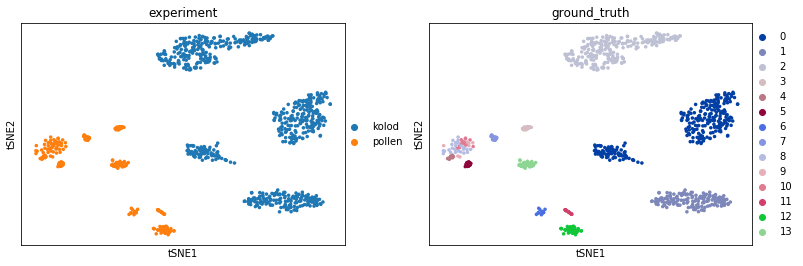

In [8]:
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X')
sc.pp.pca(adata, n_comps=50)
sc.tl.tsne(adata)
sc.pl.tsne(adata, color=['experiment','ground_truth'],size=50)

In [9]:
datasets = list(set(adata.obs['experiment']))
datasets

['kolod', 'pollen']

# Train and evaluate MARS

### Use Kolodziejczyk dataset as annotated, and Pollen as unannotated 

Prepare annotated, unannotated and pretrain datasets

In [10]:
kolod = adata[adata.obs['experiment'] == 'kolod',:]
pollen = adata[adata.obs['experiment'] == 'pollen',:]

In [11]:
y_kolod = np.array(kolod.obs['ground_truth'], dtype=np.int64)
annotated = ExperimentDataset(kolod.X.toarray(), kolod.obs_names, kolod.var_names, 'kolod', y_kolod)

== Dataset: Found 704 items 
== Dataset: Found 3 classes


In [12]:
y_pollen = np.array(pollen.obs['ground_truth'], dtype=np.int64) # ground truth annotations will be only used for evaluation
unannnotated = ExperimentDataset(pollen.X.toarray(), pollen.obs_names, pollen.var_names, 'pollen', y_pollen)

== Dataset: Found 249 items 
== Dataset: Found 11 classes


In [13]:
pretrain_data = ExperimentDataset(pollen.X.toarray(), pollen.obs_names, pollen.var_names, 'pollen')

In [14]:
n_clusters = len(np.unique(unannnotated.y))

Initialize MARS

In [15]:
mars = MARS(n_clusters, params, [annotated], unannnotated, pretrain_data, hid_dim_1=1000, hid_dim_2=100)

Run MARS in evaluation mode. Ground truth annotations will be used to evaluate MARS performance and scores will be returned

In [16]:
# return both annotated and unannotated datasets with save_all_embeddings
adata, landmarks, scores = mars.train(evaluation_mode=True, save_all_embeddings=True) # evaluation mode

Pretraining..

=== Epoch: 30 ===
Train acc: 1.0


... storing 'MARS_labels' as categorical


Check MARS performance

In [17]:
scores

{'accuracy': 0.9236947791164659,
 'adj_mi': 0.9271767769183966,
 'adj_rand': 0.9325569982091786,
 'f1_score': 0.8820128102241789,
 'nmi': 0.9389804034910628,
 'precision': 0.8937590187590186,
 'recall': 0.8912337662337663}

Visualize in MARS embedding space

In [18]:
adata

AnnData object with n_obs × n_vars = 953 × 8138 
    obs: 'MARS_labels', 'experiment', 'truth_labels'
    obsm: 'MARS_embedding'

In [19]:
#create anndata object using MARS embeddings as X
adata_mars = AnnData(adata.obsm['MARS_embedding'])
adata_mars.obs['MARS_labels'] = pd.Categorical(adata.obs['MARS_labels'])
adata_mars.obs['ground_truth'] = pd.Categorical(adata.obs['truth_labels'])
adata_mars.obs['experiment'] = pd.Categorical(adata.obs['experiment'])

In [20]:
np.shape(adata_mars.X) # 100-dimensional MARS embeddings space

(953, 100)

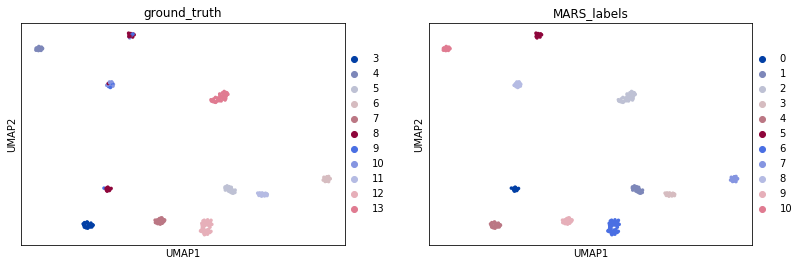

In [21]:
# visualize only unannotated dataset
pollen_mars = adata_mars[adata_mars.obs['experiment'] == 'pollen',:]
sc.pp.neighbors(pollen_mars, n_neighbors=30, use_rep='X')
sc.tl.umap(pollen_mars)
sc.pl.umap(pollen_mars, color=['ground_truth','MARS_labels'],size=50)

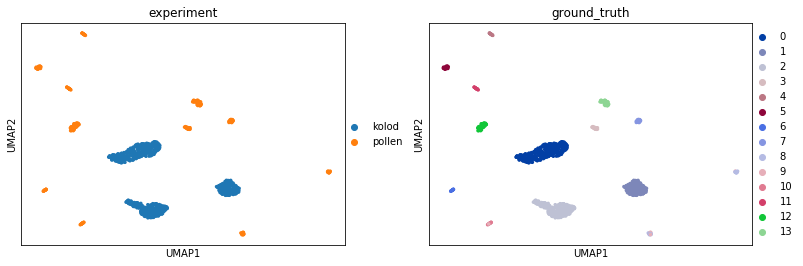

In [22]:
#visualize annotated and unannotated datasets jointly
sc.pp.neighbors(adata_mars, n_neighbors=30, use_rep='X')
sc.tl.umap(adata_mars)
sc.pl.umap(adata_mars, color=['experiment','ground_truth'], size=50)

### Use Pollen dataset as annotated, and Kolodziejczyk as unannotated

In [23]:
annotated = ExperimentDataset(pollen.X.toarray(), pollen.obs_names, pollen.var_names, 'pollen', y_pollen)
unannnotated = ExperimentDataset(kolod.X.toarray(), kolod.obs_names, kolod.var_names, 'kolod', y_kolod)
pretrain_data = ExperimentDataset(kolod.X.toarray(), kolod.obs_names, kolod.var_names, 'kolod')
n_clusters = len(np.unique(unannnotated.y))

== Dataset: Found 249 items 
== Dataset: Found 11 classes
== Dataset: Found 704 items 
== Dataset: Found 3 classes


Run MARS

In [27]:
mars = MARS(n_clusters, params, [annotated], unannnotated, pretrain_data, hid_dim_1=1000, hid_dim_2=100)

In [28]:
# return both annotated and unannotated datasets with save_all_embeddings
adata, landmarks, scores = mars.train(evaluation_mode=True, save_all_embeddings=True) # evaluation mode

Pretraining..

=== Epoch: 30 ===
Train acc: 0.9959839582443237


... storing 'MARS_labels' as categorical


In [29]:
scores

{'accuracy': 0.9659090909090909,
 'adj_mi': 0.8908128290672772,
 'adj_rand': 0.9079056032181991,
 'f1_score': 0.9624739115161284,
 'nmi': 0.8982423423300416,
 'precision': 0.9562841530054644,
 'recall': 0.9728813559322034}

In [30]:
#create anndata object using MARS embeddings as X
adata_mars = AnnData(adata.obsm['MARS_embedding'])
adata_mars.obs['MARS_labels'] = pd.Categorical(adata.obs['MARS_labels'])
adata_mars.obs['ground_truth'] = pd.Categorical(adata.obs['truth_labels'])
adata_mars.obs['experiment'] = pd.Categorical(adata.obs['experiment'])

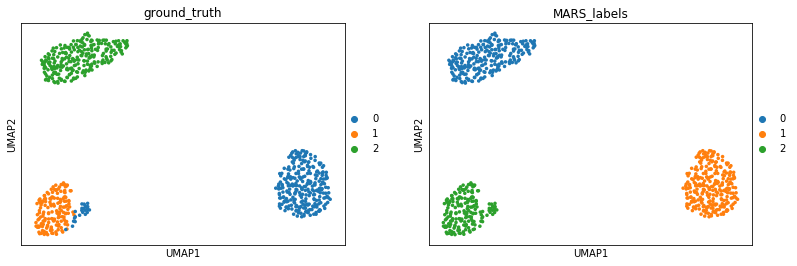

In [31]:
# visualize only unannotated dataset
kolod_mars = adata_mars[adata_mars.obs['experiment'] == 'kolod',:]
sc.pp.neighbors(kolod_mars, n_neighbors=30, use_rep='X')
sc.tl.umap(kolod_mars)
sc.pl.umap(kolod_mars, color=['ground_truth','MARS_labels'],size=50)

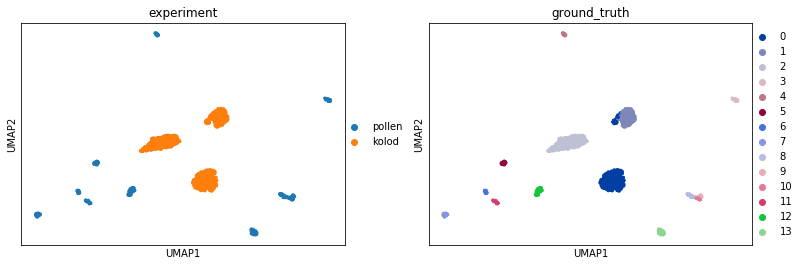

In [32]:
#visualize annotated and unannotated datasets jointly
sc.pp.neighbors(adata_mars, n_neighbors=30, use_rep='X')
sc.tl.umap(adata_mars)
sc.pl.umap(adata_mars, color=['experiment','ground_truth'], size=50)